In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')

import pandas as pd

In [11]:
#units in the millions
def pop_pyramid(data,window_len=5):
    pop = np.array([[x/5.0]*5 for x in data]).flatten()
    window = np.ones(window_len)/window_len
    return np.convolve(pop,window,mode='same')

In [12]:
#Step Parameters
age_classes = 105   # Number of discrete age groups
timesteps = 50     # Number of time steps to simulate

ages = np.arange(age_classes)
time = np.arange(timesteps)
A,T = np.meshgrid(ages,time)

In [13]:
official_males = np.zeros((timesteps, age_classes))
official_females = np.zeros((timesteps, age_classes))

for i in range(timesteps):
    df = pd.read_csv(f'China_Data/China-{1979+i}.csv')
    official_males[i] = pop_pyramid(df['M']/1e6,window_len=1)
    official_females[i] = pop_pyramid(df['F']/1e6,window_len=1)

In [14]:
def plots(males, females, figurename):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    top_level = int(max(np.max(males),np.max(females))+1)+1
    levels = np.arange(0, top_level, 1)
    ax1.contourf(A,T+1979,females,levels=levels,cmap='Reds')
    ax1.axhline(y=2025, color='g', linestyle='-')
    ax1.set_title('Female Population')
    ax1.set_ylabel('Time')
    ax1.set_xlabel('Age')

    ax2.contourf(A,T+1979,males,levels=levels,cmap='Blues')
    ax2.axhline(y=2025, color='g', linestyle='-')
    ax2.set_title('Male Population')
    ax2.set_xlabel('Age')
    cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, orientation='vertical')
    cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, orientation='vertical')
    f.suptitle(f'Population Pyramid ({figurename})')
    f.savefig(f'age_{figurename}')

    plt.figure()
    s_females = np.sum(females,axis=1)
    s_males = np.sum(males,axis=1)
    plt.plot(time+1979,s_females,color='red',linestyle='--',label='Females (model)')
    plt.plot(time+1979,s_males,color='blue',linestyle='--',label='Males (model)')
    plt.plot(time+1979,np.sum(official_females,axis=1),color='red',linestyle='-',label='Females (official)')
    plt.plot(time+1979,np.sum(official_males,axis=1),color='blue',linestyle='-',label='Males (official)')
    plt.legend(loc='upper left')
    plt.axvline(x=2025,color='g',linestyle='-')
    plt.axvline(x=1979+float(np.argmax(s_females)),color='r',linestyle=':')
    plt.axvline(x=1979+float(np.argmax(s_males)),color='b',linestyle=':')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f'Population over Time ({figurename})')
    plt.savefig(f'total_{figurename}')

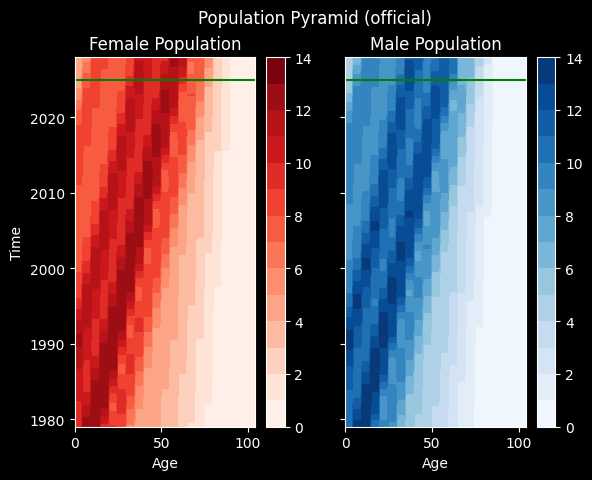

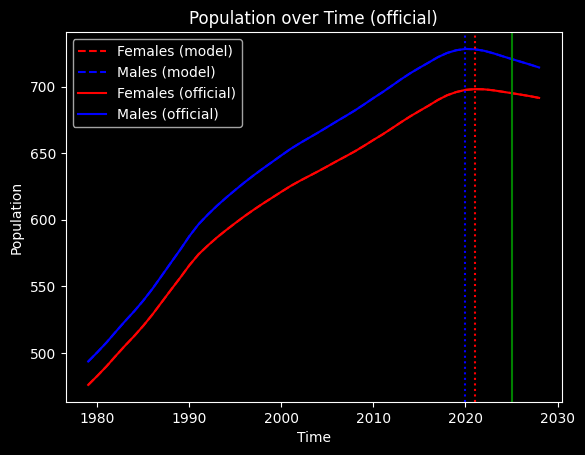

In [15]:
plots(official_males,official_females,'official')

In [16]:
# Data from https://www.populationpyramid.net/china/1979/
df = pd.read_csv('China_Data/China-1979.csv')
china_males = pop_pyramid(df['M']/1e6)
china_females = pop_pyramid(df['F']/1e6)

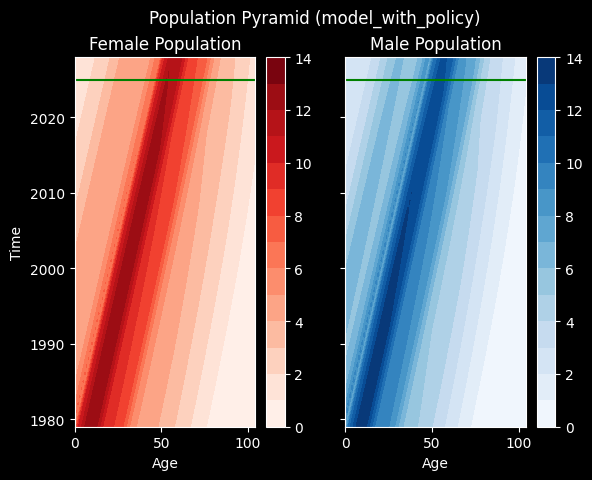

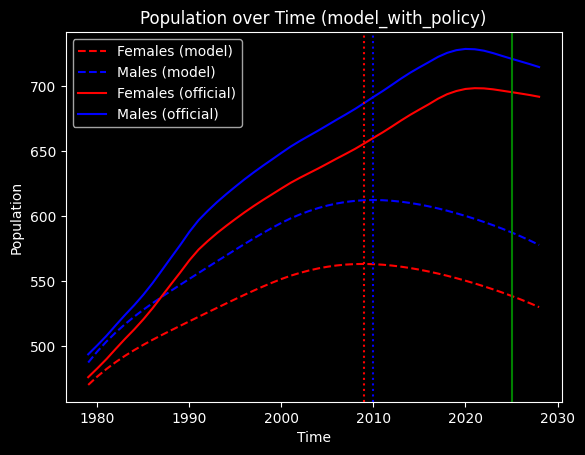

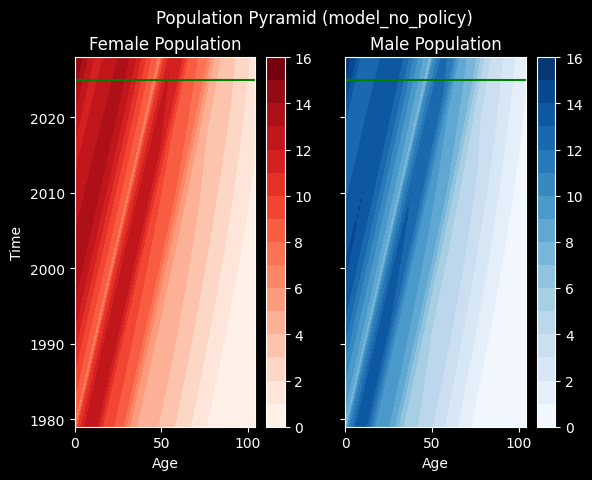

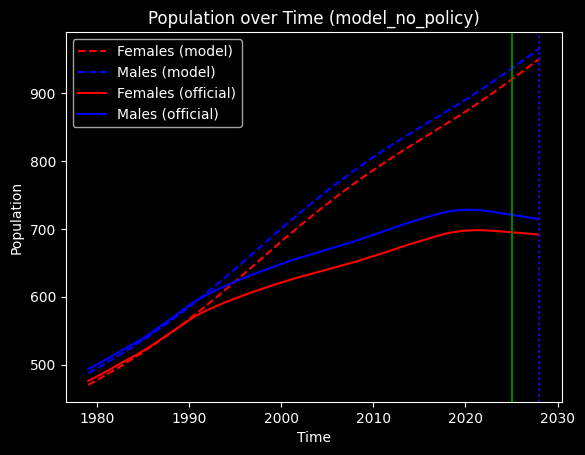

In [17]:
for one_child in [True,False]:
    # Parameters
    a = 0.57 if one_child else 0.51             # Sex ratio (fraction male)
    birth_scale = 2.5

    female_years = np.arange(22,41)
    male_years = np.arange(22,60)

    # Mortality rates per year
    mortality_female = lambda ages: np.clip(0.0002 * np.exp(0.05 * (ages+0.5)), 0, 1)
    mortality_male   = lambda ages: np.clip(0.0003 * np.exp(0.05 * (ages+0.5)), 0, 1)

    # Survival probabilities
    survival_female = 1 - mortality_female(ages)
    survival_male   = 1 - mortality_male(ages)

    S_x = np.zeros((age_classes, age_classes))
    S_y = np.zeros((age_classes, age_classes))

    for i in range(age_classes - 1):
        S_x[i + 1, i] = survival_female[i]
        S_y[i + 1, i] = survival_male[i]

    # Fertility matrix K 
    K = np.zeros((age_classes, age_classes))
    for i in female_years:
        K[i + 1, i] = birth_scale / len(female_years)

    # Initial population vectors
    fecund_females = np.zeros((timesteps, age_classes))
    fecund_males = np.zeros((timesteps, age_classes))
    parent_females = np.zeros((timesteps, age_classes))
    parent_males = np.zeros((timesteps, age_classes))
    fecund_females[0] = china_females
    fecund_males[0] = china_males

    # Simulation
    for t in time[:-1]:
        # Compute Mating
        babies = np.sum(K @ fecund_females[t])
        new_mothers = K @ fecund_females[t] if one_child else 0.0
        # Handle Normal Mortality and parental transitions
        parent_females[t+1] = S_x @ parent_females[t] + new_mothers
        parent_males[t+1] = S_y @ parent_males[t]
        fecund_females[t+1] = S_x @ fecund_females[t] - new_mothers
        fecund_males[t+1] = S_y @ fecund_males[t]
        # New Babies
        fecund_females[t+1][0] = (1 - a) * babies
        fecund_males[t+1][0] = a * babies

    females = fecund_females + parent_females
    males = fecund_males + parent_males
    plots(males,females,f'model_{'with' if one_child else 'no'}_policy')

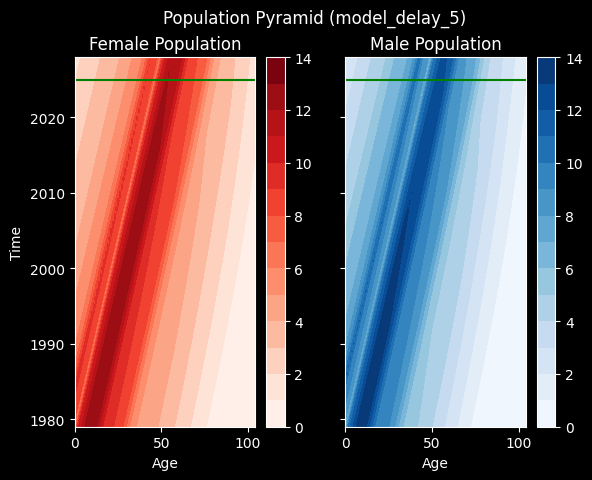

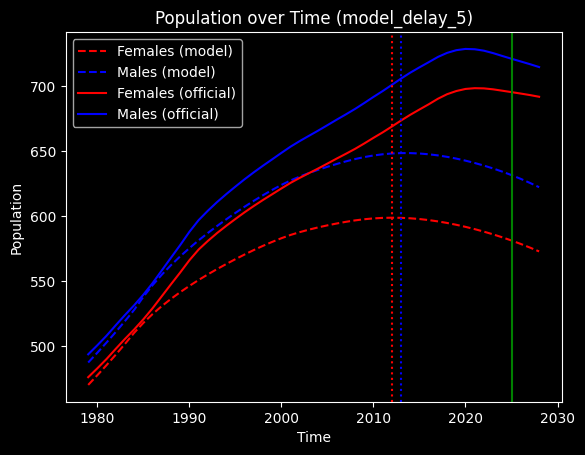

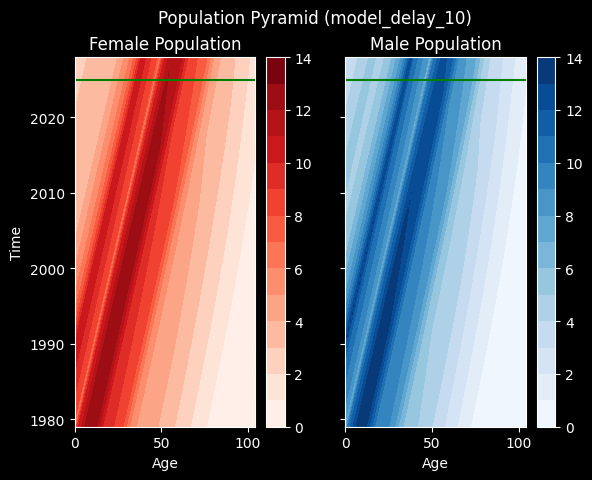

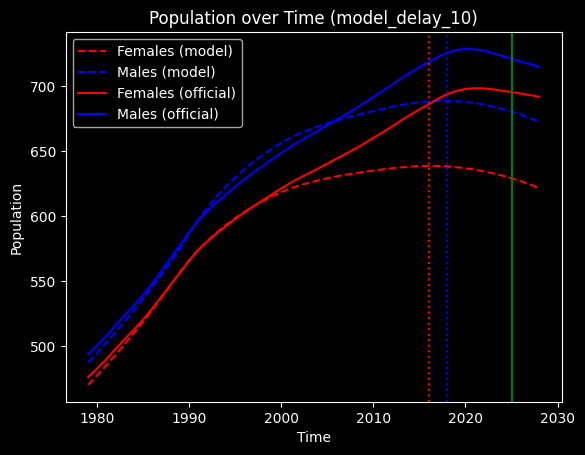

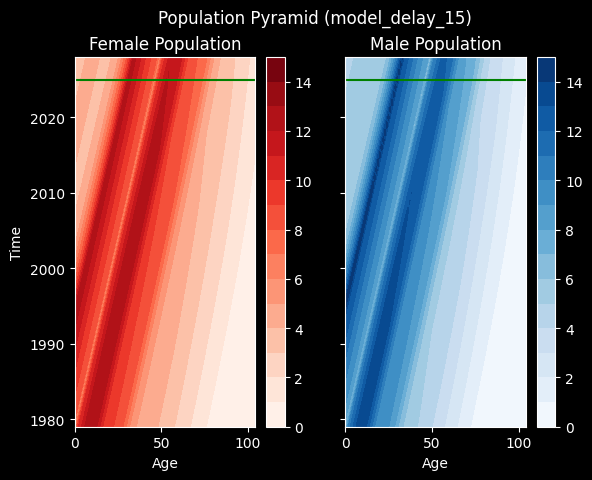

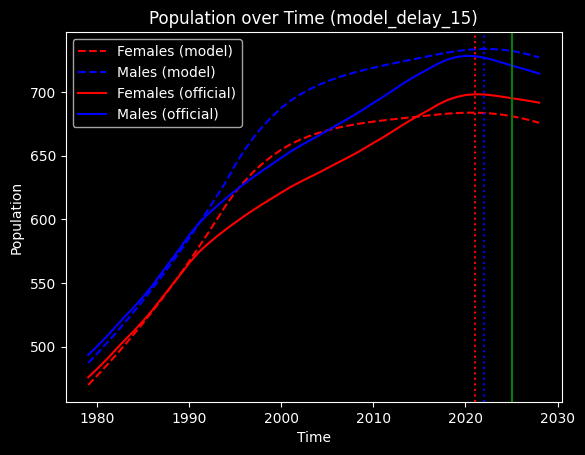

In [18]:
# Parameters
for delay in [5,10,15]:
    a = lambda one_child: 0.57 if one_child else 0.51             # Sex ratio (fraction male)
    birth_scale = 2.5

    female_years = np.arange(22,41)
    male_years = np.arange(22,60)

    # Mortality rates per year
    mortality_female = lambda ages: np.clip(0.0002 * np.exp(0.05 * (ages+0.5)), 0, 1)
    mortality_male   = lambda ages: np.clip(0.0003 * np.exp(0.05 * (ages+0.5)), 0, 1)

    # Survival probabilities
    survival_female = 1 - mortality_female(ages)
    survival_male   = 1 - mortality_male(ages)

    S_x = np.zeros((age_classes, age_classes))
    S_y = np.zeros((age_classes, age_classes))

    for i in range(age_classes - 1):
        S_x[i + 1, i] = survival_female[i]
        S_y[i + 1, i] = survival_male[i]

    # Fertility matrix K 
    K = np.zeros((age_classes, age_classes))
    for i in female_years:
        K[i + 1, i] = birth_scale / len(female_years)

    # Initial population vectors
    fecund_females = np.zeros((timesteps, age_classes))
    fecund_males = np.zeros((timesteps, age_classes))
    parent_females = np.zeros((timesteps, age_classes))
    parent_males = np.zeros((timesteps, age_classes))
    fecund_females[0] = china_females
    fecund_males[0] = china_males

    # Simulation
    for t in time[:-1]:
        one_child = (t>=delay)
        # Compute Mating
        babies = np.sum(K @ fecund_females[t])
        new_mothers = K @ fecund_females[t] if one_child else 0.0
        # Handle Normal Mortality and parental transitions
        parent_females[t+1] = S_x @ parent_females[t] + new_mothers
        parent_males[t+1] = S_y @ parent_males[t]
        fecund_females[t+1] = S_x @ fecund_females[t] - new_mothers
        fecund_males[t+1] = S_y @ fecund_males[t]
        # New Babies
        fecund_females[t+1][0] = (1 - a(one_child)) * babies
        fecund_males[t+1][0] = a(one_child) * babies

    females = fecund_females + parent_females
    males = fecund_males + parent_males
    plots(males,females,f'model_delay_{delay}')